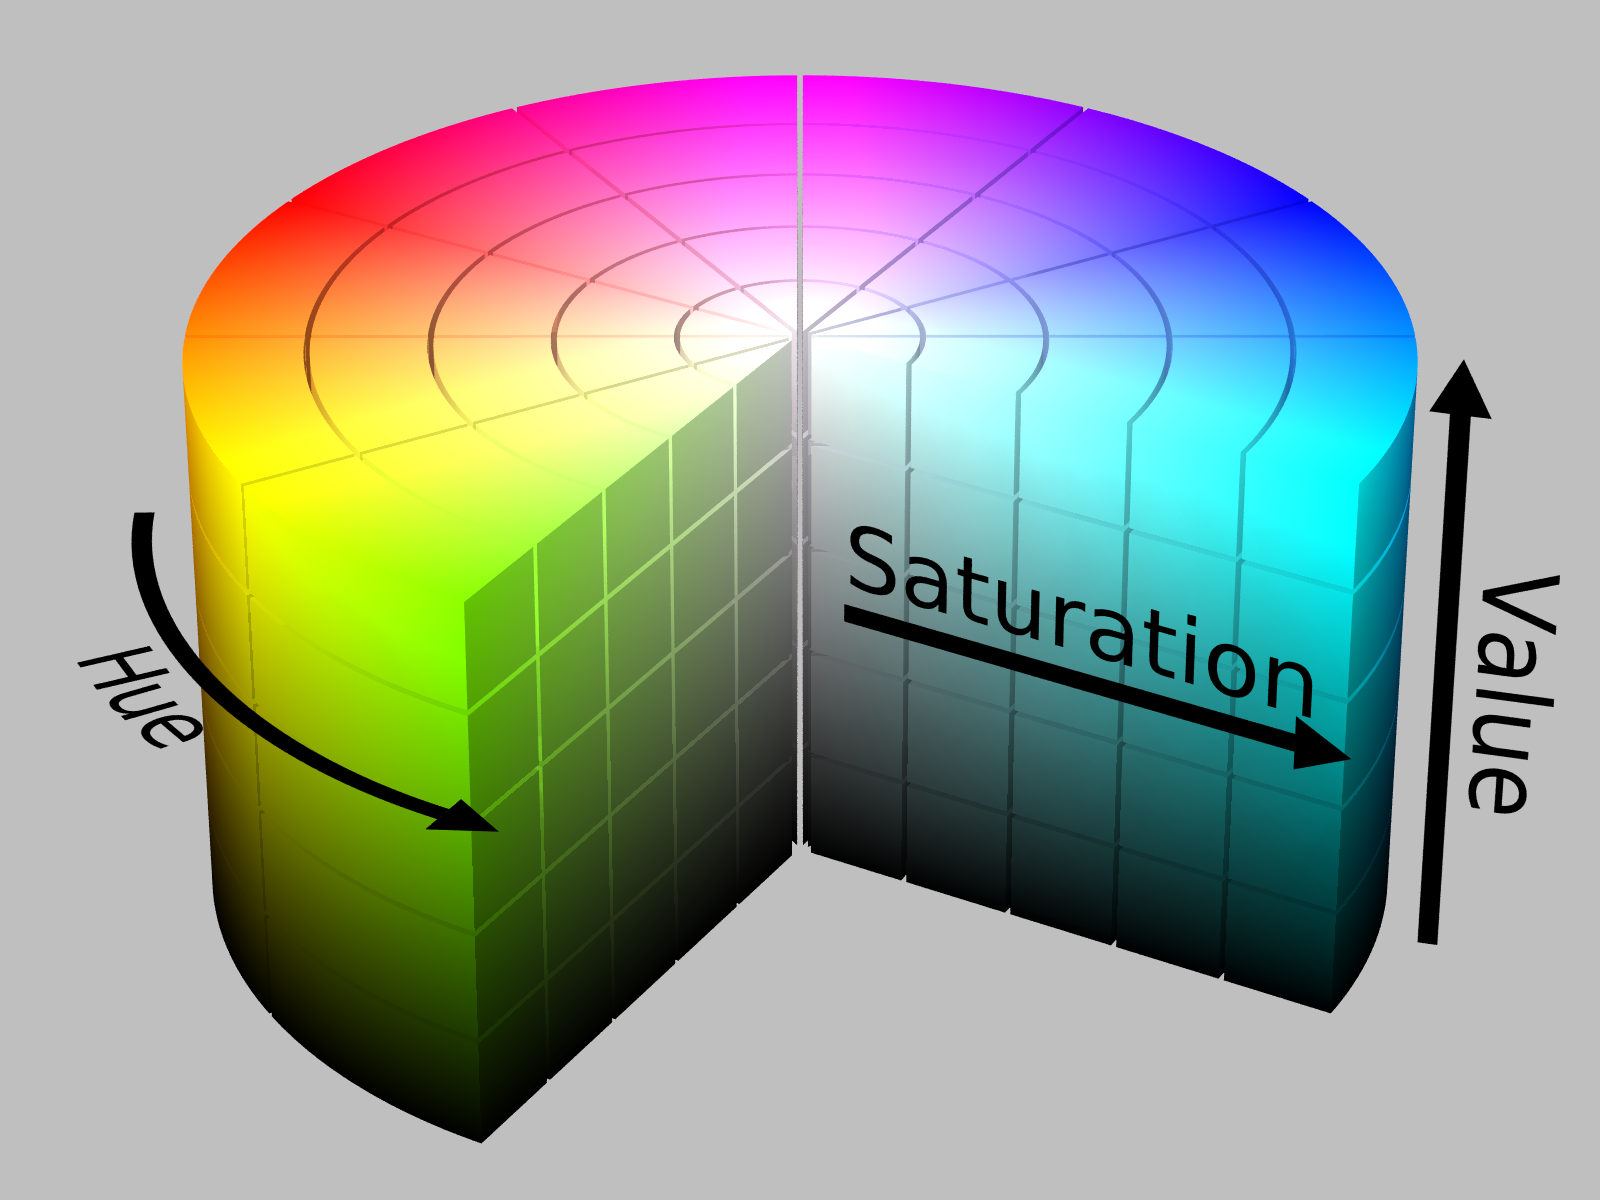

In [1]:
from skspatial.objects import Points, Plane
from skspatial.plotting import plot_3d
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_name = "Plant_holder.jpg"

def reader(name):
     #load
    img = cv2.imread(name)
    return img
    

### Get mask

In [1]:
def get_mask(img, plot = False):
    
    """Finds object(several to handle to be defined) in frame """
    
    #smoothen
    img = cv2.medianBlur(img,5)

    #resize
    scale = 0.1
    new_height = int(img.shape[0]*scale)
    new_width  = int(img.shape[1]*scale)
    img = cv2.resize(img, (new_width, new_height),interpolation = cv2.INTER_AREA)
    
    #define BGR orange color range for BGR thresholding
    l_orange = np.array([10,50,175],dtype = np.float32)
    u_orange = np.array([40,73,210],dtype = np.float32)
    
    #opening to get rid of the small background artifacts
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    
    #thresholding and open
    mask = cv2.inRange(img, l_orange, u_orange)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if plot:
        #bitwise and mask and original picture
        res = cv2.bitwise_and(img,img, mask= mask)
        cv2.imshow('result',res)
        cv2.imshow('mask BGR',mask)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return mask

### Additional stuffs

In [ ]:
# Kmeans
clust = img.reshape((-1,3))
clust = np.float32(clust) #should be flattened and of type float32
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10,1.0) #max iter and accuracy epsilon
K = 3 #2 clusters
ret, label, center = cv2.kmeans(clust, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
clust = res.reshape((img.shape))
    
# Print
#cv2.imshow('K-means',clust)
#cv2.imshow('Original', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


# Convert to hsv format
#hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define orange color range for HSV thresholding
#low_orange = np.array([5,211,186],dtype = np.float32)
#upp_orange = np.array([6.5,255,255],dtype = np.float32)


### Create trackcolourbar

In [ ]:
def nothing(x):
    pass

# Create a black image, a window
img = np.zeros((300,512,3), np.uint8)
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('R','image',0,255,nothing)
cv2.createTrackbar('G','image',0,255,nothing)
cv2.createTrackbar('B','image',0,255,nothing)

# create switch for ON/OFF functionality
switch = '0 : OFF \n1 : ON'
cv2.createTrackbar(switch, 'image',0,1,nothing)

while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

    # get current positions of four trackbars
    r = cv2.getTrackbarPos('R','image')
    g = cv2.getTrackbarPos('G','image')
    b = cv2.getTrackbarPos('B','image')
    s = cv2.getTrackbarPos(switch,'image')

    if s == 0:
        img[:] = 0
    else:
        img[:] = [b,g,r]

cv2.destroyAllWindows()

### Find centroid

In [29]:
def find_centroid(img, mask, verbose = False):
    """Returns centroid in image coordinates
        Args: 2D image (3 channels RGB)
              mask (1/0)
    """
    
    # Find moments based on contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    M = cv2.moments(cnt)

    # Find centroid
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Plots
    if verbose:
        # Centroid pixels coordinates
        print("x : {}, y : {}".format(cx,cy))
        # Print centroid
        cv2.circle(img, (int(cx),int(cy)), 2, 255, 2)
        # Draw contours
        cv2.drawContours(img, contours, -1, (255, 0, 0), 2) # image, contours, contourIdx, color, thickness
        cv2.imshow('centroid',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        
    return [cx, cy]

x : 186, y : 189


## Get object orientation (3D normal vector)
https://www.ilikebigbits.com/2015_03_04_plane_from_points.html

In [ ]:
def get_plane_orientation(mask, img, depth): #is depth included in the image ?
    """
    Computes normal vector of object plane
    Args: mask (1/0) with only one object detected at the moment
          2D image (2D vector 3 channels)
          depth (2D vector 1 channel)"""
    
    # 1- Compute object coordinates
    
    # compute object depth by applying a mask
    obj_depth = mask * depth
    # compute object coordinates
    xy_i = np.nonzero(obj_depth) #(x,y) pixels coordinates, corrected nan entries
    nz_objdepth = obj_depth[np.nonzero(obj_depth)] #depth (z) coordinates BUT pbm with return type -> returns tuple
    # convert in camera coordinates frame
    
    # convert in world coordinates frame
    points_abs = #([x,y,z]) dim: N x 3 absolute position
    
    # 2- Find 3D plane
    
    # compute 3D plane variables and normal
    pts = Points(points_abs) #must be built with a nd.array
    plane = Plane.best_fit(points)
    
    return np.array(plane.normal)
    

### Full Algorithm
https://www.ilikebigbits.com/2015_03_04_plane_from_points.html

In [ ]:
# 2 - Compute least squares
    
    # trick
    centroid = np.sum(points_abs,axis = 0) / points_abs.shape[0]
    points_rel = points_abs - centroid #relative position to centroid 
    # matrix coefs
    xx = points_rel[:,0].T @ points_rel[:,0] #dim : 1 x N x N x 1 = 1
    xy = points_rel[:,0].T @ points_rel[:,1]
    xz = points_rel[:,0].T @ points_rel[:,2]
    yy = points_rel[:,1].T @ points_rel[:,1]
    yz = points_rel[:,1].T @ points_rel[:,2]
    zz = points_rel[:,2].T @ points_rel[:,2]
    # det calculations -> at least one of the components of the normal must be nz 
    #if the points do span a plane (which we have also to check)
    det_x = yy*zz - yz**2
    det_y = xx*zz - xz**2
    det_z = xx*yy - xy**2
    det_max = max(det_x,det_y,det_z) #keep the max
    # check if plane
    if abs(det_max) < 1e-9:
        print("Error, no plane was found".)
        return None
    # else compute plane normal vector

## Convert from image to world space

In [ ]:
def image_2_world(points, depth):
    """Converts image 2D coordinates (array) to 3D world space coordinates
    Args: points (2D array)
          depth  (1D array)
          """
    

## Trials

In [2]:
points = Points([[0, 0, 0], [1, 3, 5], [-5, 6, 3], [3, 6, 7], [-2, 6, 7]])
plane = Plane.best_fit(points)

In [5]:
vec = np.array(plane.normal)
vec

array([-0.35081243, -0.69449919,  0.62817315])